In [24]:
import numpy as np
import pandas as pd
import os
import glob
import re
import textiling
import segmentation
import nltk
from sentence_transformers import SentenceTransformer

import konlpy
from konlpy.tag import Okt
import matplotlib.pylab as plt
%matplotlib inline


In [25]:
dir_path = "./texts/"

In [26]:
def load_data(name, version):
    path = dir_path + name + "_" + version + "_data.txt"
    text = ""
    with open(path, "r") as f:
        lines = f.readlines()

    for line in lines:
        text += line

    return text

kakao_origin = load_data("kakao", "origin")
kakao_stem = load_data("kakao", "stem")
band_origin = load_data("band", "origin")
band_stem = load_data("band", "stem")
nate_origin = load_data("nate", "origin")
nate_stem = load_data("nate", "stem")

In [27]:
tt = textiling.TextTilingTokenizer()
kakao_cos_tt = tt.tokenize(kakao_origin, mode = "cos")
kakao_origin_tt = tt.tokenize(kakao_stem, mode = "origin")
band_cos_tt = tt.tokenize(band_origin, mode = "cos")
band_origin_tt = tt.tokenize(band_stem, mode = "origin")
nate_cos_tt = tt.tokenize(nate_origin, mode = "cos")
nate_origin_tt = tt.tokenize(nate_stem, mode = "origin")

In [50]:
# Segment example 1 <= n1 < n2 <= 20
def print_seg(tt, n1, n2):
    n2 = min(len(tt), n2)
    for i in range(n1-1, n2+1):
        print(tt[i])
        print("-"*150)

print_seg(band_cos_tt, 1, 4)

희 집 근처에는 병원 있어?
응, 난 엄청 근처에 있어.
나는 차 타고 20분 거리에 있어.
집 근처에 병원이 있으면 편리한 거 같아.
왜 그렇게 생각하는 거야?
언제 사고가 발생할지 모르잖아.
사고가 나면 병원을 빨리 가는 게 중요해.
나는 집 근처에 병원이 있어서 다행이야.
20분 정도 거리면 나도 나름 가까운 거 같아.
다음에 이사 가면 근처에 병원 있는지 꼭 확인해야겠어.
------------------------------------------------------------------------------------------------------------------------------------------------------
나도 참고해야지.
미리 대비하는 모습 좋은 거 같아.
나는 경유차가 첫차였어
아 노후 경유차였구나
노후 경유차면 운행이 쉽진 않지
서울은 여기저기 감시 카메라가 많아가지고 끌고 다니기 힘들었어
그러니깐 요즘은 블랙박스로 찍어서 신고도 많이하니깐
요즘은 진짜 차 끌고 다닐때 조심해야돼
맞어 블랙박스가 있어서 너무 좋으면서도 조심 또 조심해야돼
너네는 단속카메라에 걸린적 없어?
나 너무 많지 딱지 날라올때마다 피눈물이
나도 주정차 단속이랑 과속 한번씩 있는데 진짜 눈물나
나도 어디 갔다가 주차할때가 없어서 잠깐 세웠는데 과태료 날라오더라
차가 편하기도 하면서 더 불편한 부분도 있어
근데 단속 중이면 문자오는건가 ? 그런것도 있어
그게 뭐야? 단소을 알려준다고?
그런게 있어? 찾아봐야겠다
너희 일할 때 mbti 뭐야?
나는 해봤는데 ENTJ야.
J들이 꼼꼼하고 계획적이긴 하지
회사에서 칭찬 받겠다
나는 덤벙대는 성격이라 부럽다
우리 회사도 그런 사람 몇 명 있어
-----------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
def origin_pred(tt):
    origin_label = [0]
    for origin_t in tt:
        origin_label.append(origin_label[-1] + len(origin_t.strip().split("\n\n\t")))

    return origin_label[1:]

def cos_pred(tt):
    cos_label = [0]
    for cos_t in tt:
        cos_label.append(cos_label[-1] + len(cos_t.split("\n")))

    return cos_label[1:]

kakao_origin_pred = origin_pred(kakao_origin_tt)
kakao_cos_pred = cos_pred(kakao_cos_tt)
band_origin_pred = origin_pred(band_origin_tt)
band_cos_pred = cos_pred(band_cos_tt)
nate_origin_pred = origin_pred(nate_origin_tt)
nate_cos_pred = cos_pred(nate_cos_tt)


In [29]:
def load_label(data_name):
    with open(dir_path + data_name+"_label.txt") as f:
        label = [int(x) for x in f.readline().strip().split(" ")]
    return label

kakao_label = load_label("kakao")
band_label = load_label("band")
nate_label = load_label("nate")

In [30]:
def draw_graph(label, cos_pred, origin_pred):
    plt.figure(figsize=(20,2))
    for i in (label):
        plt.axvline(x = i, color="r", linewidth = 1)
    for i in (cos_pred):
        plt.axvline(x = i, color="b", linewidth = 1)
    for i in (origin_pred):
        plt.axvline(x = i, color="y", linewidth = 1)
    plt.show()

Red line -> label  
Blue line -> cosine similarity method  
Yellow line -> original method

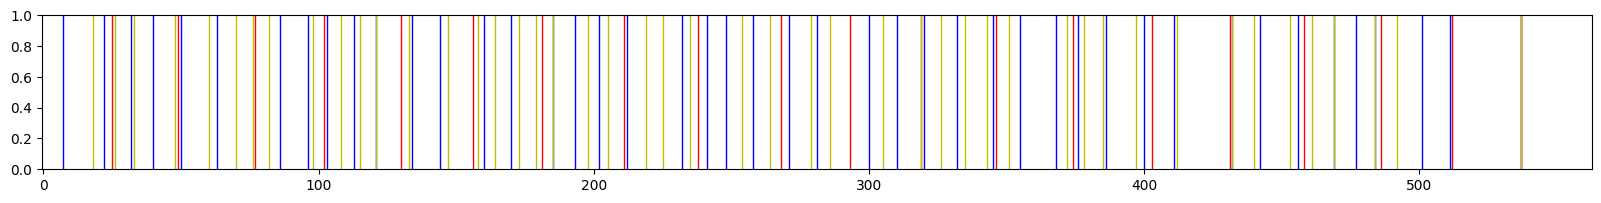

In [31]:
draw_graph(kakao_label, kakao_cos_pred, kakao_origin_pred)

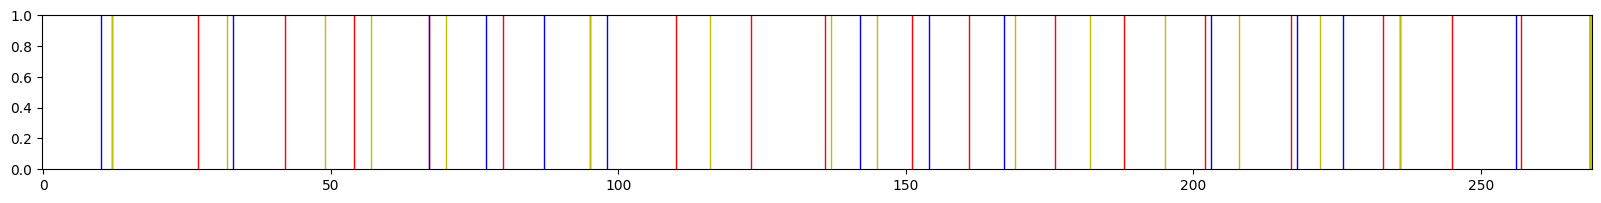

In [32]:
draw_graph(band_label, band_cos_pred, band_origin_pred)

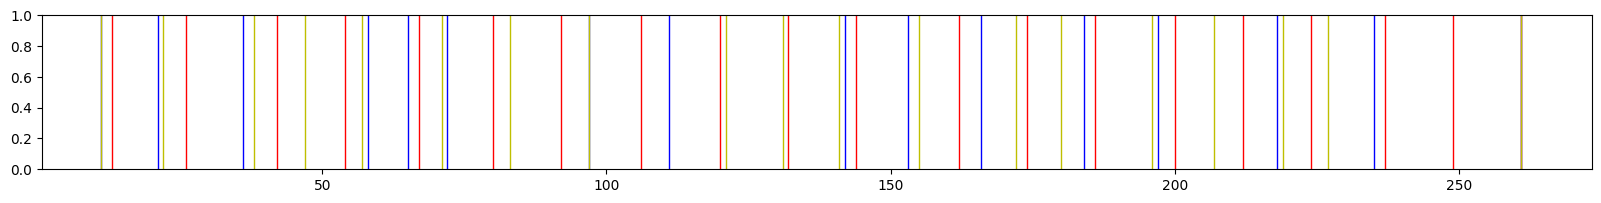

In [33]:
draw_graph(nate_label, nate_cos_pred, nate_origin_pred)

In [34]:
def evaluate_windowdiff(label, pred, n):
    label_s = ""
    pred_s = ""
    for i in range(max(label[-1], pred[-1])+1):
        if i in label:
            label_s += "1"
        else:
            label_s += "0"

        if i in pred:
            pred_s += "1"
        else:
            pred_s += "0"

    return segmentation.windowdiff(label_s, pred_s, n)

print(f'original texttiling kakao data score {evaluate_windowdiff(kakao_label, kakao_origin_pred, 3)}')
print(f'cos similarity texttiling kakao data score {evaluate_windowdiff(kakao_label, kakao_cos_pred, 3)}')
print(f'original texttiling band data scroe {evaluate_windowdiff(band_label, band_origin_pred, 3)}')
print(f'cos similarity texttiling band data score {evaluate_windowdiff(band_label, band_cos_pred, 3)}')
print(f'original texttiling nate data scroe {evaluate_windowdiff(nate_label, nate_origin_pred, 3)}')
print(f'cos similarity texttiling nate data score {evaluate_windowdiff(nate_label, nate_cos_pred, 3)}')

original texttiling kakao data score 0.30783582089552236
cos similarity texttiling kakao data score 0.2891791044776119
original texttiling band data scroe 0.3208955223880597
cos similarity texttiling band data score 0.2947761194029851
original texttiling nate data scroe 0.38076923076923075
cos similarity texttiling nate data score 0.35384615384615387
